In [1]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid')

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 70)

import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import _sets_path_to_root
_sets_path_to_root("pypsa-africa")

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/pypsa-africa
Had to go 1 folder(s) up.


# Load all networks

In [32]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# clustered_network = os.getcwd() + '/networks/elec_s_10.nc'
solved_network = os.getcwd() + '/results/networks/elec_s_10_ec_lcopt_Co2L-3H_old.nc'

# n_add_el = pypsa.Network(add_electricity_network)
# n_cluster = pypsa.Network(clustered_network)
n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_50_old.nc has buses, carriers, generators, lines, loads
INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-3H_old.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


# Solved network

In [4]:
n = n_solve

In [5]:
n.global_constraints

,sense,constant,type,investment_period,carrier_attribute,mu
name,,,,,,
CO2Limit,<=,77500000.0,primary_energy,NaN,co2_emissions,0.0


In [15]:
# EURO/MWh
n.objective/n.loads_t.p.sum().sum()

58.173081899480934

### Spatial temporal resolution

/home/max/anaconda3/envs/toast/lib/python3.9/site-packages/pypsa/plot.py:149: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection=projection)


(<matplotlib.collections.PatchCollection at 0x7fb7859acaf0>,
 <matplotlib.collections.LineCollection at 0x7fb7859c5280>)

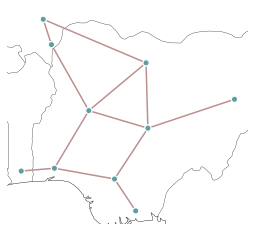

In [7]:
n.plot()

In [8]:
#temporal resolution - timesteps
len(n.snapshots)

2920

### Overview components

In [9]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 30 entries
Component 'Carrier' has 6 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 12 entries
Component 'LineType' has 31 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 40 entries
Component 'Load' has 10 entries
Component 'Generator' has 20 entries
Component 'Store' has 20 entries


### Energy balance

In [ ]:
# Difference between total load and generation
n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum() - substract storage losses

### Total installed generator capacity

In [10]:
gen_cap = n.generators.groupby(['carrier']).p_nom_opt.sum()
gen_cap

carrier
onwind    3.199475e+06
solar     3.199475e+06
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot'>

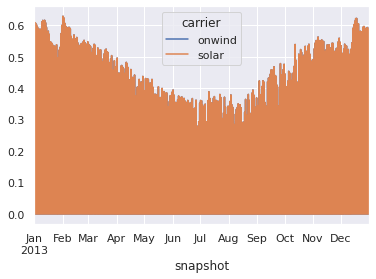

In [14]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [25]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

8.279457688331604e-07

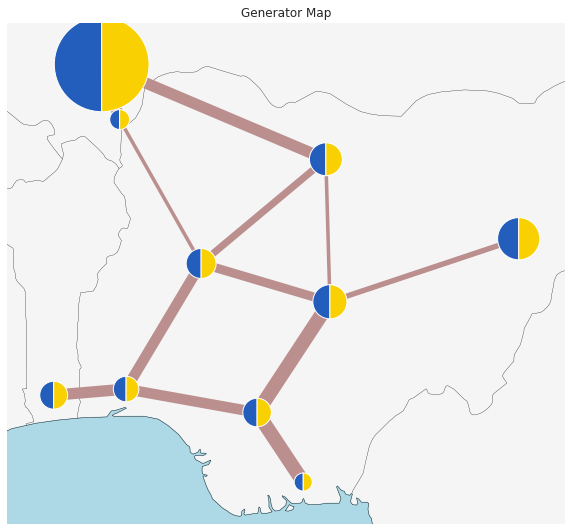

In [44]:
fig,ax = plt.subplots(
        figsize=(10,10),
        subplot_kw={"projection":ccrs.PlateCarree()} #PlateCarree(default), Mercator, Orthographic
)

#loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(margin=0.1, 
        ax=None, 
        geomap=True, #'10m' leads to a beautiful high resolution map 
        projection= None, 
        bus_colors='cadetblue', 
        bus_alpha=1, 
        bus_sizes=n.generators.iloc[:,:].groupby(['bus','carrier']).p_nom_opt.sum()*.0000003, 
        bus_cmap=None, 
        line_colors='rosybrown', 
        link_colors='darkseagreen', #loading
        transformer_colors='orange', 
        line_widths=n.lines.s_nom_opt/3e2, 
        link_widths=1.5, 
        transformer_widths=1.5, 
        line_cmap=None, 
        link_cmap=None, #plt.cm.virdis (colordmap for line loading)
        transformer_cmap=None, 
        flow=None, 
        branch_components=None, 
        layouter=None, 
        title='Generator Map', 
        boundaries=None, 
        geometry=False, 
        jitter=None, 
        color_geomap=True)#None or True

ax.axis('off');

### Demand

<AxesSubplot:xlabel='snapshot'>

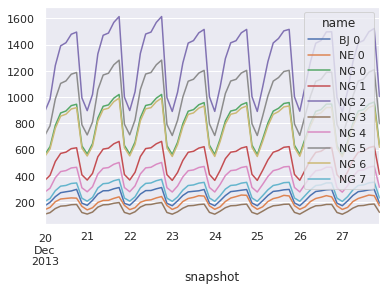

In [61]:
n.loads_t.p.loc["2013-12-20":"2013-12-27"].plot()

### Plot of Average Marginal Price

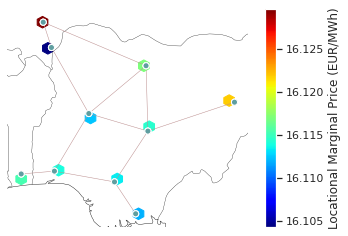

In [35]:
now = n.snapshots[4] ##one specific time

fig,ax = plt.subplots(1,1,subplot_kw={"projection":ccrs.PlateCarree()})
fig.set_size_inches(6,4)

n.plot(ax=ax,line_widths=pd.Series(0.5,n.lines.index))
plt.hexbin(n.buses.x, n.buses.y, 
           gridsize=20,
           #C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
           C=n.buses_t.marginal_price.sum()/len(n.snapshots[:]), #Marginal price averaged over the whole year (My version) 
                                                                 #- shows in which regions electricity will be cheap and where el. intensive companies should be placed.
           cmap=plt.cm.jet)

#for some reason the colorbar only works with graphs plt.plot
#and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (EUR/MWh)')

### Storage

<AxesSubplot:xlabel='snapshot'>

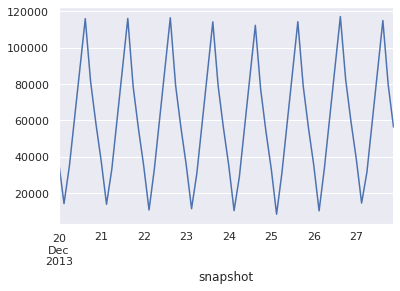

In [18]:
n.stores_t.e.loc["2013-12-20":"2013-12-27"].sum(axis=1).plot()

In [56]:
n.links.iloc[:].groupby(['carrier']).p_nom_opt.sum()

carrier
H2 electrolysis       11630.840324
H2 fuel cell          13061.934633
battery charger           0.339570
battery discharger        0.377299
Name: p_nom_opt, dtype: float64